In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 使用示例
filename = 'hit5.log'  # 你的文件名
num_layer = 32
init_block = 1
local_block = 32
block_size = 128

In [3]:
def process_access_history(filename, num_layer, init_block, local_block, block_size):
    # 创建计数数组
    
    
    # 读取文件并统计每个 block 的访问次数
    with open(filename, 'r') as f:
        sum_tokens = int(f.readline())
        num_mid_tokens = sum_tokens - (init_block + local_block) * block_size
        num_blocks = (num_mid_tokens+block_size-1)//block_size-1 + init_block + local_block
        block_counts = np.zeros([num_layer, num_blocks])
        cur_layer = 0
        for line in f:
            # 将字符串转换为 list
            blocks = eval(line.strip())
            for block_id in range(init_block):
                block_counts[cur_layer][block_id] += 1
            for block_id in range(local_block):
                block_counts[cur_layer][num_blocks - local_block + block_id] += 1
            # 统计每个 block 的出现次数
            for block_id in blocks:
                block_counts[cur_layer][block_id+init_block]+= 1
            cur_layer = (cur_layer + 1)%num_layer

        assert cur_layer == 0
    return block_counts
block_counts = process_access_history(filename, num_layer, init_block, local_block, block_size)

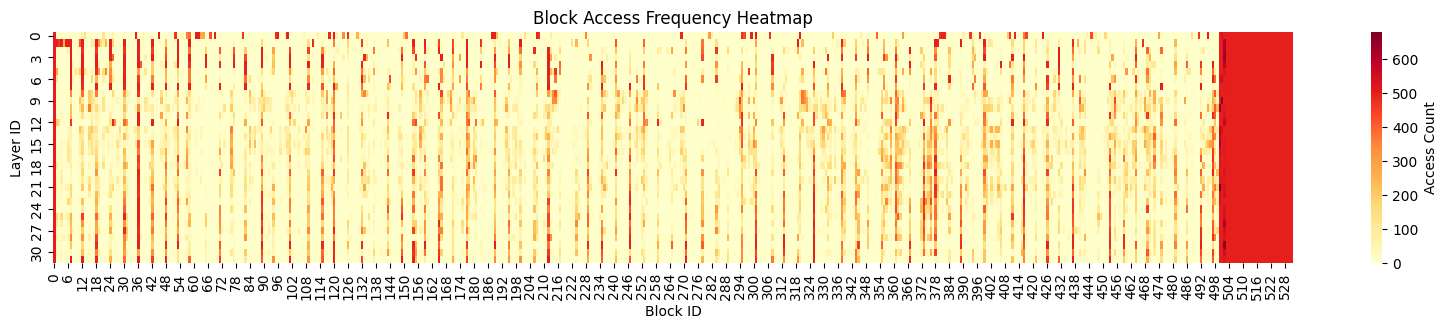

In [4]:
def plot_access_heatmap(heatmap_data):
    plt.figure(figsize=(20, 3))
    sns.heatmap(heatmap_data, 
                cmap='YlOrRd',  # 使用黄-橙-红色系
                annot=False,    # 不显示具体数值
                fmt='.0f',
                cbar_kws={'label': 'Access Count'})
    
    plt.title('Block Access Frequency Heatmap')
    plt.xlabel('Block ID')
    plt.ylabel('Layer ID')
    plt.show()
plot_access_heatmap(block_counts)

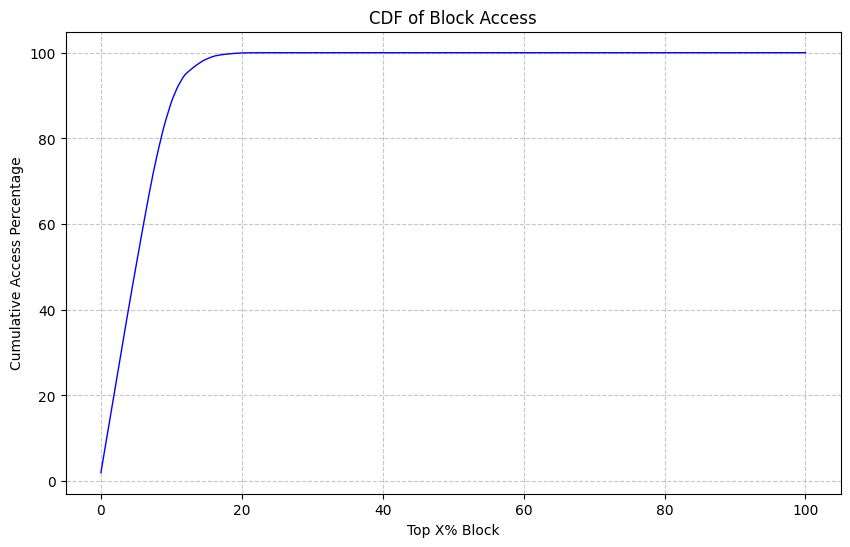

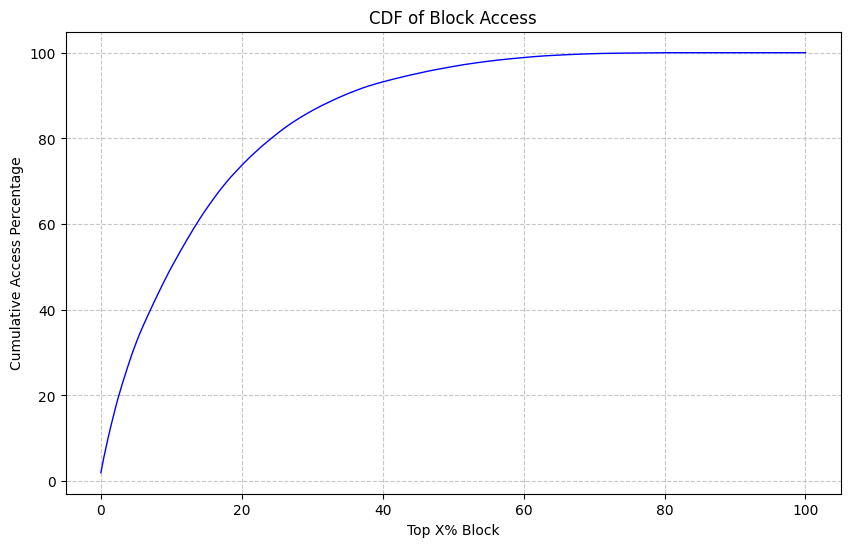

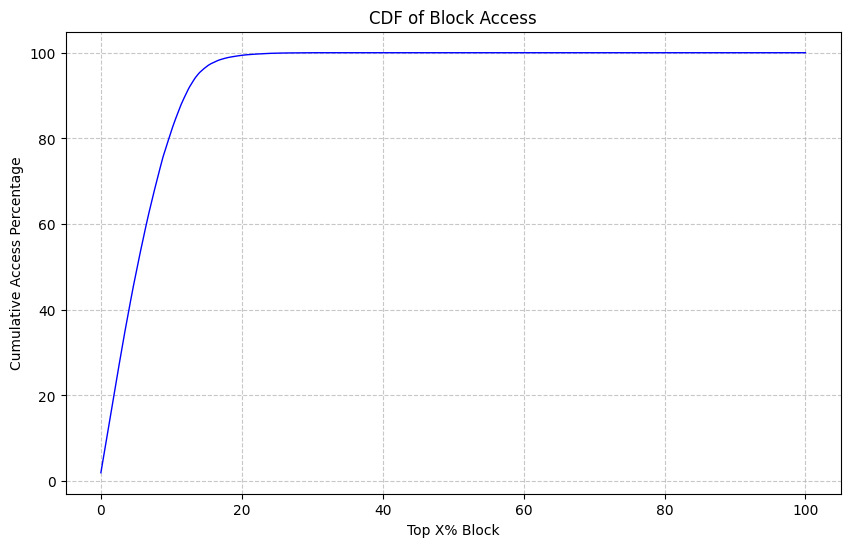

In [7]:
def plot_access_cdf(block_counts):
    
    # 对 block_counts 进行降序排序
    sorted_counts = np.sort(block_counts)[::-1]
    # 计算累计访问次数
    cumulative_counts = np.cumsum(sorted_counts)
    # 转换为占比
    cumulative_percent = cumulative_counts / cumulative_counts[-1] * 100
    # 生成对应的 x 轴数据（top-x% 的 block）
    x_percent = np.linspace(0, 100, len(cumulative_percent))
    
    # 绘制 CDF 图
    plt.figure(figsize=(10, 6))
    plt.plot(x_percent, cumulative_percent, 'b-', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xlabel('Top X% Block')
    plt.ylabel('Cumulative Access Percentage')
    plt.title('CDF of Block Access')    
    plt.show()

# plot_access_cdf(block_counts[0])
plot_access_cdf(block_counts[0][:-local_block])
# plot_access_cdf(block_counts[8])
# plot_access_cdf(block_counts[8][:-local_block])
# plot_access_cdf(block_counts[16])
plot_access_cdf(block_counts[16][:-local_block])
# plot_access_cdf(block_counts[24])
# plot_access_cdf(block_counts[24][:-local_block])
# plot_access_cdf(block_counts[31])
plot_access_cdf(block_counts[31][:-local_block])